# Gut Microbiome of HIV+ Individuals in Rural Appalachia

In [1]:
!qiime info

System versions
Python version: 3.8.12
QIIME 2 release: 2021.11
QIIME 2 version: 2021.11.0
q2cli version: 2021.11.0

Installed plugins
alignment: 2021.11.0
composition: 2021.11.0
cutadapt: 2021.11.0
dada2: 2021.11.0
deblur: 2021.11.0
demux: 2021.11.0
diversity: 2021.11.0
diversity-lib: 2021.11.0
emperor: 2021.11.0
feature-classifier: 2021.11.0
feature-table: 2021.11.0
fragment-insertion: 2021.11.0
gneiss: 2021.11.0
longitudinal: 2021.11.0
metadata: 2021.11.0
phylogeny: 2021.11.0
quality-control: 2021.11.0
quality-filter: 2021.11.0
sample-classifier: 2021.11.0
taxa: 2021.11.0
types: 2021.11.0
vsearch: 2021.11.0

Application config directory
/Users/johnsterrett/mambaforge/envs/qiime2-2021.11/var/q2cli

Getting help
To get help with QIIME 2, visit https://qiime2.org


In [1]:
import os
import sys
import subprocess

from qiime2 import Artifact, Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import kruskal, ttest_ind
from skbio import TreeNode

%matplotlib inline

## Initial processing
### Unzip files

`outputs = []
for zipped in os.listdir("hiv-fastqs/"):
    bashCommand = f"unzip hiv-fastqs/{zipped} -d hiv-fastqs/"
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    outputs.append((output,error))
`    

`! rm hiv-fastqs/*.zip`

### Import data to qiime2 artifact

`! qiime tools import \
--type 'SampleData[PairedEndSequencesWithQuality]' \
--input-path hiv-fastqs/ \
--input-format CasavaOneEightSingleLanePerSampleDirFmt \
--output-path demux-paired-end.qza`

### Summarize the imported data

`! qiime demux summarize \
--i-data demux-paired-end.qza \
--o-visualization paired-end-summarized.qzv`

In [2]:
viz = Visualization.load("paired-end-summarized.qzv")
viz

<visualization: Visualization uuid: 93906a1a-5d08-48cc-9412-c0c4fb49e9c0>

**Thoughts** - forward

- Overall sequence quality looks awesome. 
- Looks like quality dips over the first 19 reads, which could be primers, so I'll just trim those off.
- Looks like it dips at the very end too. At bp 269, 25 percentile of PHRED is still >30, so I'll truncate there.

Trimming at 19 and 269 still gives us 250 bp - well more than we need, so that's good!

**Thoughts** - reverse
- Overall sequence quality looks good. 
- Not sure if the sequencing folks used reverse primers, so I'll trim at 19 again to be safe. Need to check in on this.
- Looks like it dips as it goes on. At bp 240, 50th percentile of PHRED starting to drop < 30, so I'll truncate there.

Trimming at 19 and 240 still gives us 221 bp - well more than we need, so that's good!

## Denoise using dada2

`! qiime dada2 denoise-paired \
--i-demultiplexed-seqs demux-paired-end.qza \
--p-trim-left-f 19 \
--p-trunc-len-f 269 \
--p-trim-left-r 19 \
--p-trunc-len-r 240 \
--output-dir dada2-out \
--verbose`

`! qiime feature-table summarize \
--i-table dada2-out/table.qza \
--m-sample-metadata-file metadata.txt \
--o-visualization dada2-out/table.qzv`

In [3]:
viz = Visualization.load("dada2-out/table.qzv")
viz

ValueError: dada2-out/table.qzv does not exist.

## SEPP fragment insertion for phylogenetic tree

> ! qiime fragment-insertion sepp \
--i-representative-sequences dada2-out/representative_sequences.qza \
--i-reference-database sepp-refs-silva-128.qza \
--o-tree insertion-tree.qza \
--o-placements insertion-placements.qza

> ! qiime fragment-insertion filter-features \
--i-table dada2-out/table.qza \
--i-tree insertion-tree.qza \
--o-filtered-table filtered-table.qza \
--o-removed-table removed-table.qza

## Assigning taxonomy

> ! qiime feature-classifier classify-sklearn \
--i-reads dada2-out/representative_sequences.qza \
--i-classifier silva-138-99-515-806-nb-classifier.qza \
--output-dir silva-classified

> ! qiime metadata tabulate \
--m-input-file silva-classified/classification.qza \
--o-visualization silva-classified/classification.qzv

>! mv silva-classified/classification.qza taxonomy-silva.qza 

>! mv silva-classified/classification.qzv taxonomy-silva.qzv

In [4]:
viz = Visualization.load('taxonomy-silva.qzv')
viz

<visualization: Visualization uuid: dd486f8b-be31-4bbc-a3f9-83eab4508284>

## Filter mitochondria and chloroplast

>! qiime taxa filter-table \
  --i-table filtered-table.qza \
  --i-taxonomy taxonomy-silva.qza \
  --p-exclude mitochondria,chloroplast \
  --o-filtered-table noMito_noChloro-filtered-table.qza 

In [3]:
dada2_table = Artifact.load('dada2-out/table.qza')
filtered_table = Artifact.load('filtered-table.qza')
no_M_C_table = Artifact.load('noMito_noChloro-filtered-table.qza')

df_tab = dada2_table.view(pd.DataFrame)
df_filt = filtered_table.view(pd.DataFrame)
df_MC = no_M_C_table.view(pd.DataFrame)

tables = ['df_tab', 'df_filt', 'df_MC']


total_frequencies = {x: globals()[x].values.sum() for x in tables}


print('filtered by sepp: {}'.format(total_frequencies['df_tab']-total_frequencies['df_filt']))
print('filtered by Mito/Chloro: {}'.format(total_frequencies['df_filt']-total_frequencies['df_MC']))

ValueError: dada2-out/table.qza does not exist.

## Taxa barplot

In [5]:
! qiime taxa barplot \
--i-table noMito_noChloro-filtered-table.qza \
--i-taxonomy taxonomy-silva.qza \
--m-metadata-file metadata.txt \
--o-visualization taxa-barplot.qzv

Saved Visualization to: taxa-barplot.qzv


In [6]:
viz = Visualization.load("taxa-barplot.qzv")
viz

<visualization: Visualization uuid: a452cbc1-fc73-40f9-920c-08c4ed357024>

## Diversity testing

### Core metrics

>! qiime diversity core-metrics-phylogenetic \
  --i-phylogeny insertion-tree.qza \
  --i-table noMito_noChloro-filtered-table.qza \
  --p-sampling-depth 52495 \
  --m-metadata-file metadata.txt \
  --output-dir core-diversity-results

### Rarefaction

>! qiime diversity alpha-rarefaction \
  --i-table noMito_noChloro-filtered-table.qza \
  --i-phylogeny insertion-tree.qza \
  --p-max-depth 80000 \
  --o-visualization core-diversity-results/alpha-rarefaction.qzv

In [7]:
viz = Visualization.load('core-diversity-results/alpha-rarefaction.qzv')
viz

<visualization: Visualization uuid: 40c7a712-1c89-4a11-81ba-5dd737a02ef9>

### Alpha diversity statistical testing

In [7]:
! qiime diversity alpha-group-significance \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file metadata.txt \
--o-visualization core-diversity-results/faith-pd-group-significance.qzv

Saved Visualization to: core-diversity-results/faith-pd-group-significance.qzv


In [8]:
! qiime diversity alpha-correlation \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file metadata.txt \
--o-visualization core-diversity-results/faith-pd-correlation.qzv

Saved Visualization to: core-diversity-results/faith-pd-correlation.qzv


In [8]:
viz = Visualization.load("core-diversity-results/faith-pd-group-significance.qzv")
viz

<visualization: Visualization uuid: f9ac38be-6014-4d45-8086-827255f3897e>

In [9]:
viz = Visualization.load("core-diversity-results/faith-pd-correlation.qzv")
viz

<visualization: Visualization uuid: 68eb7d94-5143-4930-8c20-99a23ecabc3c>

### Overall alpha div results 

Faith PD
- HIV not significant (p=0.61)
- Fibroscan 1 (CAP?) was (rho=0.36, p=0.019)
- BMI, Hip to waist, Fibroscan 2 p > 0.05

In [10]:
sns.set_context("talk")

In [11]:
faith = Artifact.load("core-diversity-results/faith_pd_vector.qza").view(pd.Series)
faith

metadata = pd.read_csv("metadata.txt", sep="\t", index_col="SampleID")
metadata = metadata.loc[faith.index]

<AxesSubplot: >

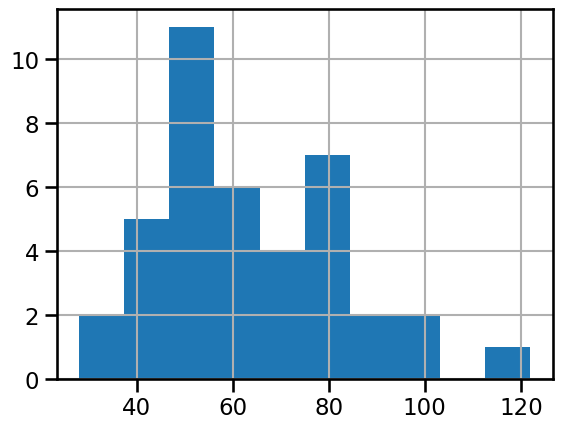

In [12]:
faith.hist()

In [13]:
faith_glm_df = pd.concat([faith,metadata], axis=1)
faith_glm_df.loc[:,"HIV"] = metadata.loc[:,"HIV"].apply(lambda x: 1 if x=="Yes" else 0)

/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/1497083756.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  faith_glm_df.loc[:,"HIV"] = metadata.loc[:,"HIV"].apply(lambda x: 1 if x=="Yes" else 0)


In [14]:
formula = "faith_pd ~ HIV*Fibroscan"
est = smf.glm(formula=formula, data=faith_glm_df).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               faith_pd   No. Observations:                   40
Model:                            GLM   Df Residuals:                       36
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          300.37
Method:                          IRLS   Log-Likelihood:                -168.75
Date:                Wed, 27 Sep 2023   Deviance:                       10813.
Time:                        12:56:50   Pearson chi2:                 1.08e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2831
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        46.1989     15.989      2.889      0.004      14.861      77.537
HIV             -51.9058     26.305     -1.973      0.048    -103.462      -0.350
Fibroscan         0.0611      0.065      0.939      0.348      -0.066       0.189
HIV:Fibroscan     0.1845      0.097      1.906      0.057      -0.005       0.374
=================================================================================
"""

HIV is significantly associated with alpha diversity when controlling for Fibroscan

In [15]:
formula = "faith_pd ~ HIV*Fibroscan_2"
est = smf.glm(formula=formula, data=faith_glm_df).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               faith_pd   No. Observations:                   40
Model:                            GLM   Df Residuals:                       36
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          356.26
Method:                          IRLS   Log-Likelihood:                -172.16
Date:                Wed, 27 Sep 2023   Deviance:                       12825.
Time:                        12:56:53   Pearson chi2:                 1.28e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1309
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          69.9553     12.678      5.518      0.000      45.108      94.803
HIV               -28.9512     17.473     -1.657      0.098     -63.197       5.295
Fibroscan_2        -1.7111      2.236     -0.765      0.444      -6.094       2.672
HIV:Fibroscan_2     5.5267      2.881      1.918      0.055      -0.120      11.174
===================================================================================
"""

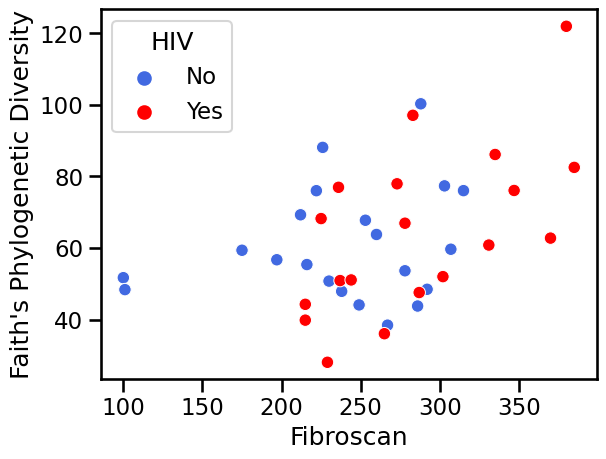

In [16]:
ax = sns.scatterplot(x="Fibroscan", y="faith_pd", hue=metadata["HIV"],
                data=faith_glm_df,
                hue_order=["No", "Yes"],
                palette=["royalblue", "red"])
ax.set_ylabel("Faith's Phylogenetic Diversity")
plt.show()

### Beta diversity statistical testing 

In [18]:
! qiime diversity beta-group-significance \
--i-distance-matrix core-diversity-results/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file metadata.txt \
--m-metadata-column HIV \
--o-visualization core-diversity-results/unweighted-unifrac-HIV-significance.qzv \
--p-pairwise

Saved Visualization to: core-diversity-results/unweighted-unifrac-HIV-significance.qzv


In [17]:
viz = Visualization.load("core-diversity-results/unweighted-unifrac-HIV-significance.qzv")
viz

<visualization: Visualization uuid: fdde7ed6-d67b-4a2c-aa45-e47c01fb1e40>

Phylogenetic community composition (Unweighted UniFrac) is associated with HIV (pseudo-F = 1.827352, p = 0.006)

In [18]:
viz = Visualization.load("core-diversity-results/u_uni_fibro_corr/mantel_scatter_visualization.qzv")
viz

<visualization: Visualization uuid: 2e507ed0-637f-4350-b393-a005583fa3bb>

Phylogenetic community composition (Unweighted UniFrac) is NOT associated with Fibroscan (Mantel test spearman rho = -0.006087, p = 0.92)

## Differential abundance

>! qiime taxa collapse \
--i-table core-diversity-results/rarefied_table.qza \
--i-taxonomy taxonomy-silva.qza --p-level 2 \
--o-collapsed-table core-diversity-results/phylum-rarefied_table.qza

>! qiime composition add-pseudocount \
--i-table core-diversity-results/phylum-rarefied_table.qza \
--o-composition-table core-diversity-results/phylum-pseudo-rarefied_table.qza

>! qiime composition ancom \
--i-table core-diversity-results/phylum-pseudo-rarefied_table.qza \
--m-metadata-file metadata.txt \
--m-metadata-column HIV \
--o-visualization core-diversity-results/ancom-phylum-HIV.qzv

In [19]:
viz = Visualization.load("core-diversity-results/ancom-phylum-HIV.qzv")
viz

<visualization: Visualization uuid: 453f46d7-c95d-4ba7-a531-257e1e6373ed>

No significant phyla found from ANCOM

In [20]:
data = Artifact.load("core-diversity-results/phylum-rarefied_table.qza").view(pd.DataFrame)

#convert to relative abundances
data_mat = np.matrix(data)
data_mat /= np.sum(data_mat, axis=1)
data = pd.DataFrame(data_mat, index=data.index, columns=data.columns)

Currently missing H19-10

In [21]:
metadata = metadata.loc[data.index]

/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/2226795640.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(x=metadata["HIV"],
/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/2226795640.py:5: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.swarmplot(x=metadata["HIV"],


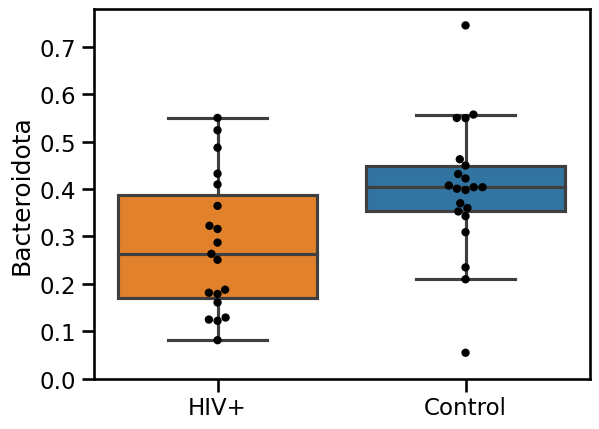

In [22]:
ax = sns.boxplot(x=metadata["HIV"],
                 y=data["d__Bacteria;p__Bacteroidota"],
                 showfliers=False,
                 palette=["tab:orange", "tab:blue"])
ax = sns.swarmplot(x=metadata["HIV"],
                   y=data["d__Bacteria;p__Bacteroidota"],
                   palette=["black"],
                   s=6,
                   ax=ax)
ax.set(ylabel="Bacteroidota",
       xlabel=None,
       xticklabels=["HIV+","Control"],
       ylim=0)
plt.tight_layout
plt.savefig("figures/HIV_Bacteroidota_poster.svg", transparent=True, bbox_inches="tight")
plt.show()

In [23]:
! qiime taxa collapse \
--i-table noMito_noChloro-filtered-table.qza \
--i-taxonomy taxonomy-silva.qza --p-level 6 \
--o-collapsed-table genus-table.qza

! qiime composition add-pseudocount \
--i-table genus-table.qza \
--o-composition-table genus-pseudo-table.qza

! qiime composition ancom \
--i-table genus-pseudo-table.qza \
--m-metadata-file metadata.txt \
--m-metadata-column HIV \
--o-visualization ancom-genus-HIV.qzv

Saved FeatureTable[Frequency] to: genus-table.qza
Saved FeatureTable[Composition] to: genus-pseudo-table.qza
Saved Visualization to: ancom-genus-HIV.qzv


In [24]:
viz = Visualization.load("ancom-genus-HIV.qzv")
viz

<visualization: Visualization uuid: 4f743846-b38e-431a-86b4-2bb6ad294d9e>

LOWER in HIV+ individuals:

d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Erysipelotrichaceae_UCG-003

In [25]:
genus = Artifact.load("genus-table.qza").view(pd.DataFrame)

#convert to relative abundances
genus_mat = np.matrix(genus)
genus_mat /= np.sum(genus_mat, axis=1)
genus = pd.DataFrame(genus_mat, index=genus.index, columns=genus.columns)

/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/3564240703.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(x=metadata["HIV"],
/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/3564240703.py:5: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.swarmplot(x=metadata["HIV"],


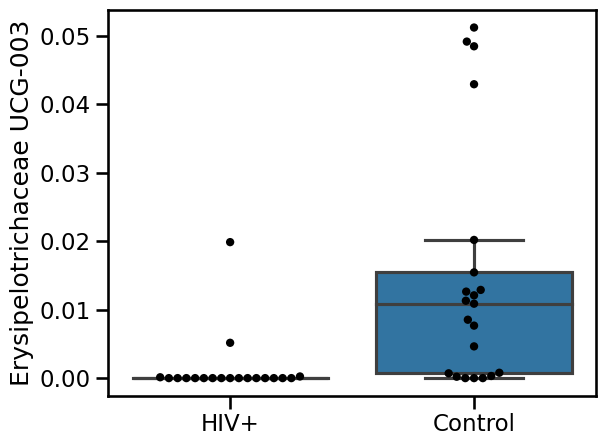

In [26]:
ax = sns.boxplot(x=metadata["HIV"],
            y=genus["d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Erysipelotrichaceae_UCG-003"], 
                 showfliers=False,
                palette=["tab:orange", "tab:blue"])
ax = sns.swarmplot(x=metadata["HIV"],
                   y=genus["d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Erysipelotrichaceae_UCG-003"], 
                   palette=["black"],
                   s=6,
                   ax=ax)
ax.set(ylabel=r"Erysipelotrichaceae UCG-003",
       xlabel=None,
       xticklabels=["HIV+","Control"])
plt.tight_layout()
plt.savefig("figures/HIV_Erysipelotrichaceae_UCG-003_poster.svg", transparent=True, bbox_inches="tight")
plt.show()

## Songbird

This was done in a QIIME2 2020.6 env because of songbird's dependencies (/opt/anaconda3/envs/qiime2-2020.6-NEW)

### Basic with just Fibroscan

>qiime songbird multinomial \
--i-table noMito_noChloro-filtered-table.qza \
--m-metadata-file metadata.txt \
--p-formula "Fibroscan" \
--p-num-random-test-examples 13 \
--p-summary-interval 1 \
--output-dir songbird_fibroscan

> qiime songbird multinomial \
--i-table noMito_noChloro-filtered-table.qza \
--m-metadata-file metadata.txt \
--p-formula "1" \
--p-num-random-test-examples 13 \
--p-summary-interval 1 \
--output-dir songbird_null

> qiime songbird summarize-single \
--i-regression-stats songbird_fibroscan/regression_stats.qza \
--o-visualization songbird_fibroscan/regression_stats.qzv

>qiime songbird summarize-paired \
--i-regression-stats songbird_fibroscan/regression_stats.qza \
--i-baseline-stats songbird_null/regression_stats.qza \
--o-visualization songbird_fibroscan_comparison.qzv

In [27]:
viz = Visualization.load("songbird_fibroscan_comparison.qzv")
viz

<visualization: Visualization uuid: e9527933-b931-4ceb-86f4-46468dfd6fd0>

Looks like the model isn't a good fit with just fibroscan. Maybe I'll try adding in some other metadata and dropping the differential prior

### HIV + Fibroscan (and hip to waist)

>! qiime songbird multinomial \
--i-table noMito_noChloro-filtered-table.qza \
--m-metadata-file metadata.txt \
--p-formula "HIV+Fibroscan+Fibroscan_2" \
--p-num-random-test-examples 13 \
--p-differential-prior 0.5 \
--p-summary-interval 1 \
--output-dir songbird_HIV_fibro1_2

> qiime songbird multinomial \
--i-table noMito_noChloro-filtered-table.qza \
--m-metadata-file metadata.txt \
--p-formula "HIV+Fibroscan+Fibroscan_2+Hip_to_Waist" \
--p-num-random-test-examples 13 \
--p-differential-prior 0.5 \
--p-summary-interval 1 \
--output-dir songbird_hiv_fibro1_2_hipwaist

> qiime songbird summarize-paired \
--i-regression-stats songbird_HIV_fibro1_2/regression_stats.qza \
--i-baseline-stats songbird_null/regression_stats.qza \
--o-visualization songbird_HIV_fibro1_2_comparison.qzv

> qiime songbird summarize-paired \
--i-regression-stats songbird_hiv_fibro1_2_hipwaist/regression_stats.qza \
--i-baseline-stats songbird_null/regression_stats.qza \
--o-visualization songbird_hiv_fibro1_2_hipwaist_comparison.qzv

In [28]:
viz = Visualization.load("songbird_HIV_fibro1_2_comparison.qzv")
viz

<visualization: Visualization uuid: 69008c14-049b-466e-b888-54d4af104b4b>

In [29]:
viz = Visualization.load("songbird_HIV_fibro1_2_hipwaist_comparison.qzv")
viz

<visualization: Visualization uuid: 47f4d5d8-4e1b-47b8-88e8-5481e134b532>

None of these models are getting great performance... 

## Gneiss

### Fibroscan gradient-based clustering

In [219]:
!qiime feature-table filter-features \
--i-table noMito_noChloro-filtered-table.qza \
--p-min-frequency 100 \
--o-filtered-table 100_filtered-table.qza

Saved FeatureTable[Frequency] to: 100_filtered-table.qza


In [220]:
!qiime gneiss gradient-clustering \
    --i-table 100_filtered-table.qza \
    --m-gradient-file metadata.txt \
    --m-gradient-column Fibroscan \
    --o-clustering fibroscan_tree.nwk.qza \
    --p-no-weighted

Saved Hierarchy to: fibroscan_tree.nwk.qza


In [221]:
!qiime composition add-pseudocount \
--i-table 100_filtered-table.qza \
--o-composition-table 100_filtered-pseudo-table.qza

Saved FeatureTable[Composition] to: 100_filtered-pseudo-table.qza


In [222]:
! qiime gneiss ilr-hierarchical \
--i-table 100_filtered-pseudo-table.qza \
--i-tree fibroscan_tree.nwk.qza \
--p-pseudocount 0 \
--o-balances fibroscan_balances.qza

Saved FeatureTable[Balance] to: fibroscan_balances.qza


In [30]:
balances = Artifact.load('fibroscan_balances.qza').view(pd.DataFrame)
tree = Artifact.load("fibroscan_tree.nwk.qza").view(TreeNode)
table = Artifact.load("100_filtered-pseudo-table.qza").view(pd.DataFrame)
taxa = Artifact.load("taxonomy-silva.qza").view(pd.DataFrame)

In [31]:
from gneiss.plot import heatmap
from gneiss.sort import ladderize
from skbio.stats.composition import clr, centralize

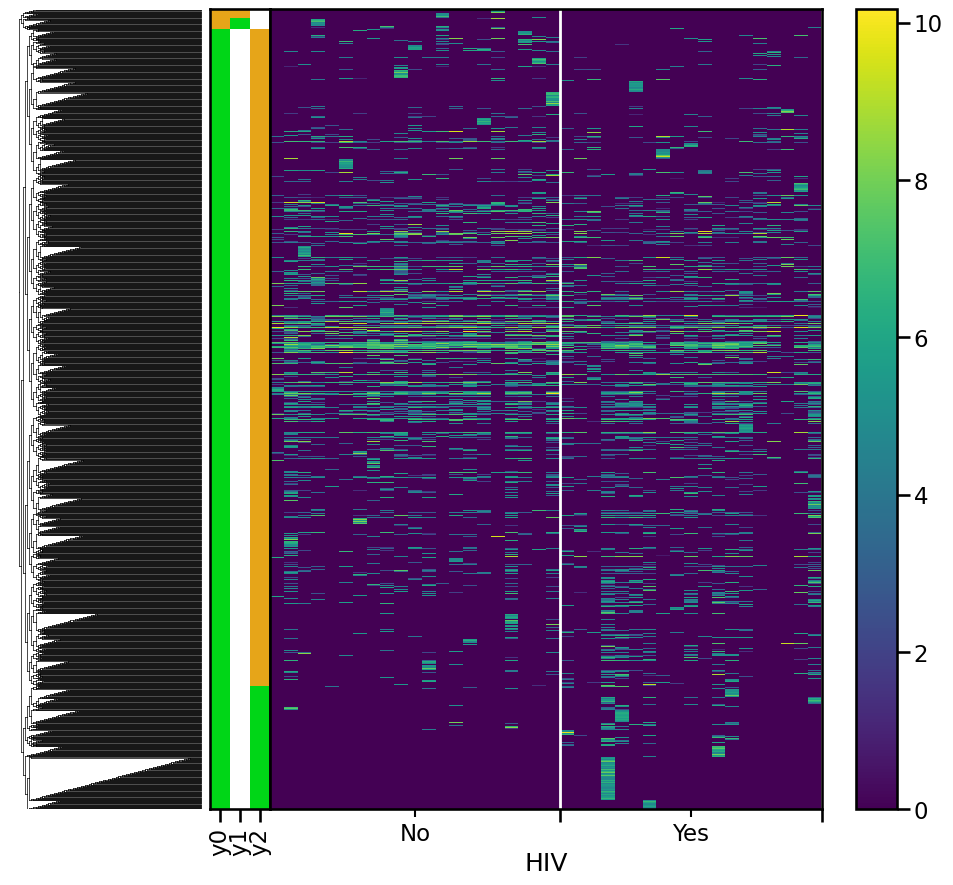

In [32]:
highlights = pd.DataFrame([['#00D617', '#E6A519'],
                           ['#00D617', '#E6A519'],
                           ['#00D617', '#E6A519']],
                          index=['y0', 'y1','y2'], 
                          columns=['numerator', 'denominator'])

_ = heatmap(np.log(table), tree, mdvar=metadata["HIV"], 
            highlights=highlights, figsize=(10, 10))

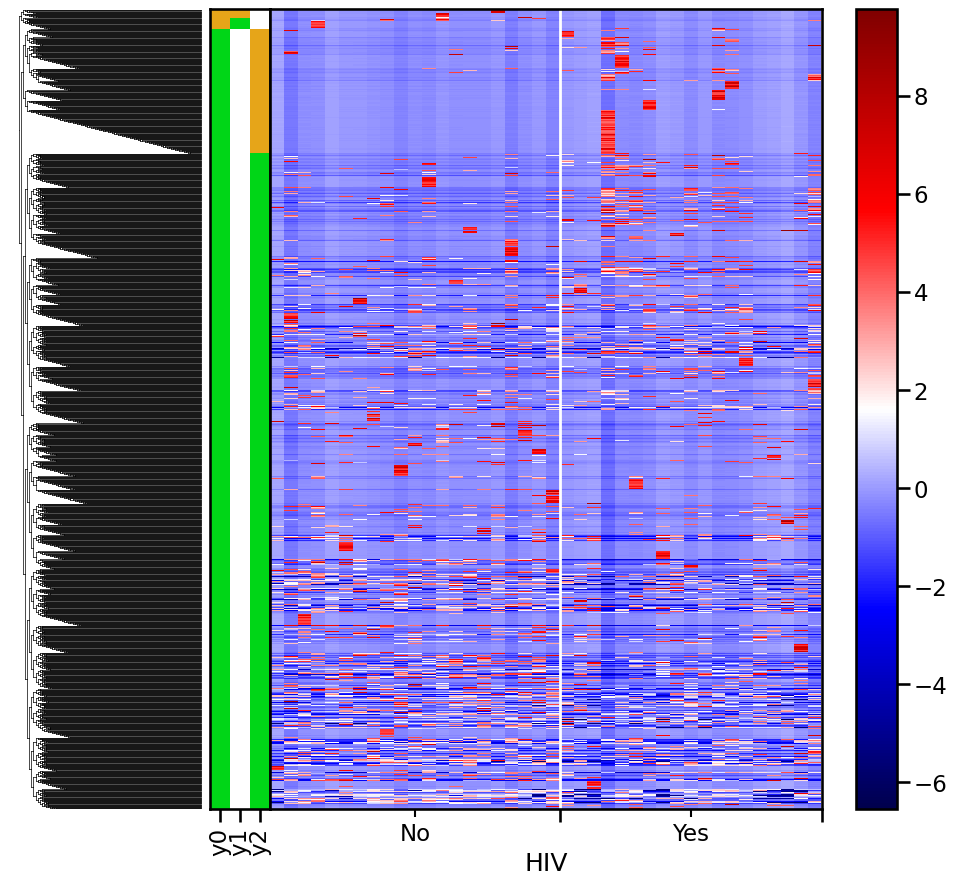

In [33]:
ctable = pd.DataFrame(clr(centralize(table)), index=table.index, columns=table.columns)

sorted_tree = ladderize(tree)

fig = heatmap(ctable, sorted_tree, mdvar=metadata["HIV"], 
            highlights=highlights, figsize=(10, 10), cmap='seismic')

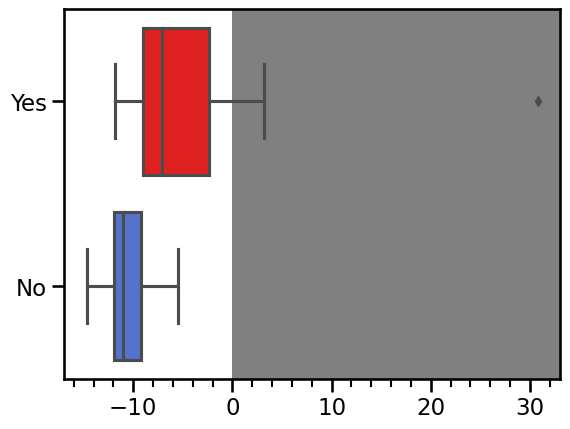

In [34]:
from gneiss.plot import balance_boxplot, balance_barplots
balance_data = pd.merge(balances, metadata, left_index=True, right_index=True)
ax = balance_boxplot('y2', balance_data, y='HIV',
                     num_color='white', denom_color='grey',
                     palette={'Yes': 'red', 'No': 'royalblue'})

In [35]:
sns.set_context("notebook")

In [36]:
taxa = pd.DataFrame(taxa.Taxon.apply(lambda x: x.split(';')).values.tolist(),
                    columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species'],
                    index=taxa.index)

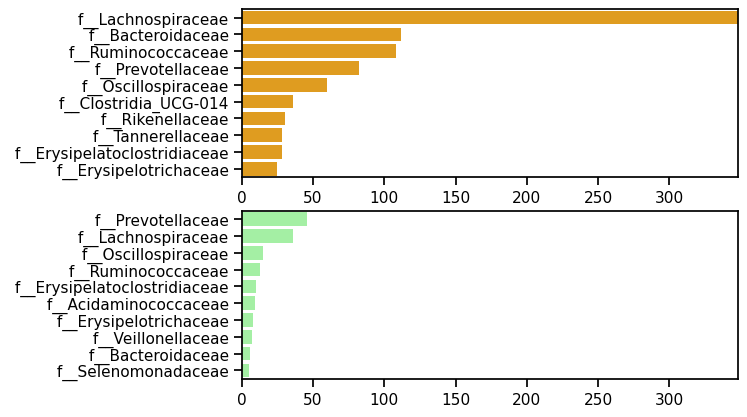

In [37]:
axes = balance_barplots(tree, 'y2', header='family', 
                        feature_metadata=taxa, ndim=10,
                        denom_color='palegreen', 
                        num_color='orange')

In [38]:
sns.set_context("talk")

### More naive co-occurrence based clustering

In [276]:
!qiime gneiss correlation-clustering \
--i-table 100_filtered-table.qza \
--o-clustering correlation_clustered_tree.qza

Saved Hierarchy to: correlation_clustered_tree.qza


In [277]:
! qiime gneiss ilr-hierarchical \
--i-table 100_filtered-pseudo-table.qza \
--i-tree correlation_clustered_tree.qza \
--p-pseudocount 0 \
--o-balances clustered_balances.qza

Saved FeatureTable[Balance] to: clustered_balances.qza


In [39]:
balances = Artifact.load('clustered_balances.qza').view(pd.DataFrame)
tree = Artifact.load("correlation_clustered_tree.qza").view(TreeNode)

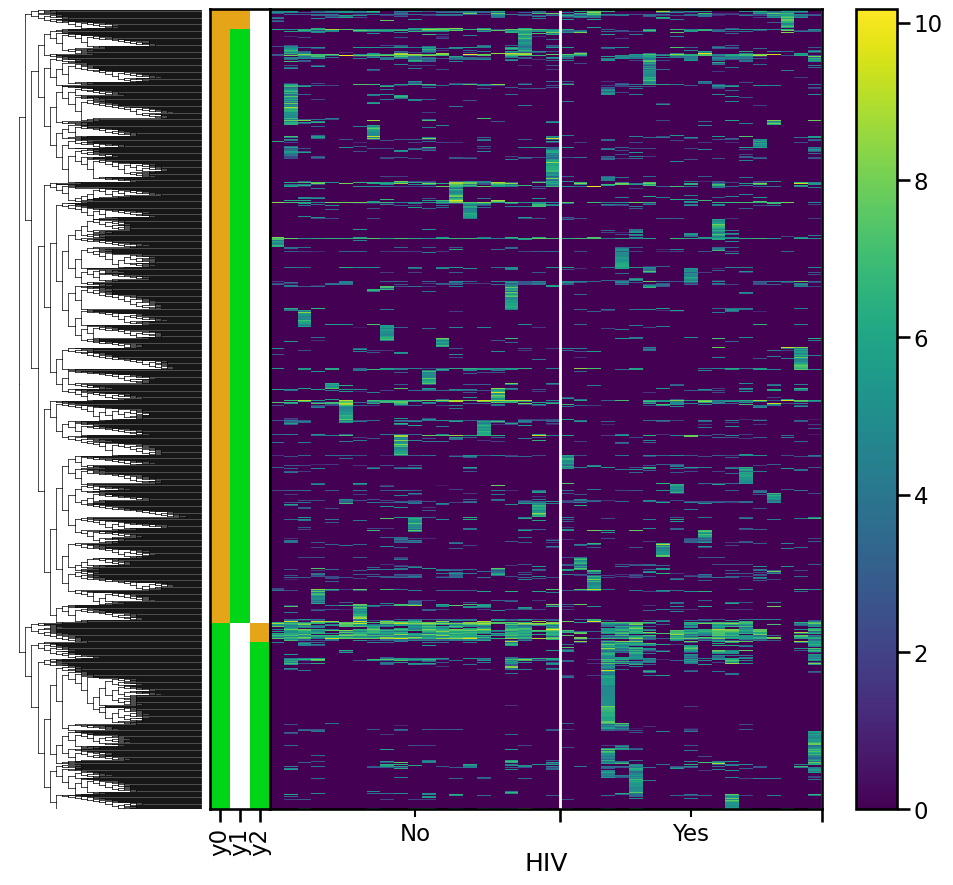

In [40]:
highlights = pd.DataFrame([['#00D617', '#E6A519'],
                           ['#00D617', '#E6A519'],
                           ['#00D617', '#E6A519']],
                          index=['y0', 'y1','y2'], 
                          columns=['numerator', 'denominator'])

_ = heatmap(np.log(table), tree, mdvar=metadata["HIV"], 
            highlights=highlights, figsize=(10, 10))

plt.savefig("figures/HIV_gneiss_heatmap.svg", transparent=True, bbox_inches="tight")

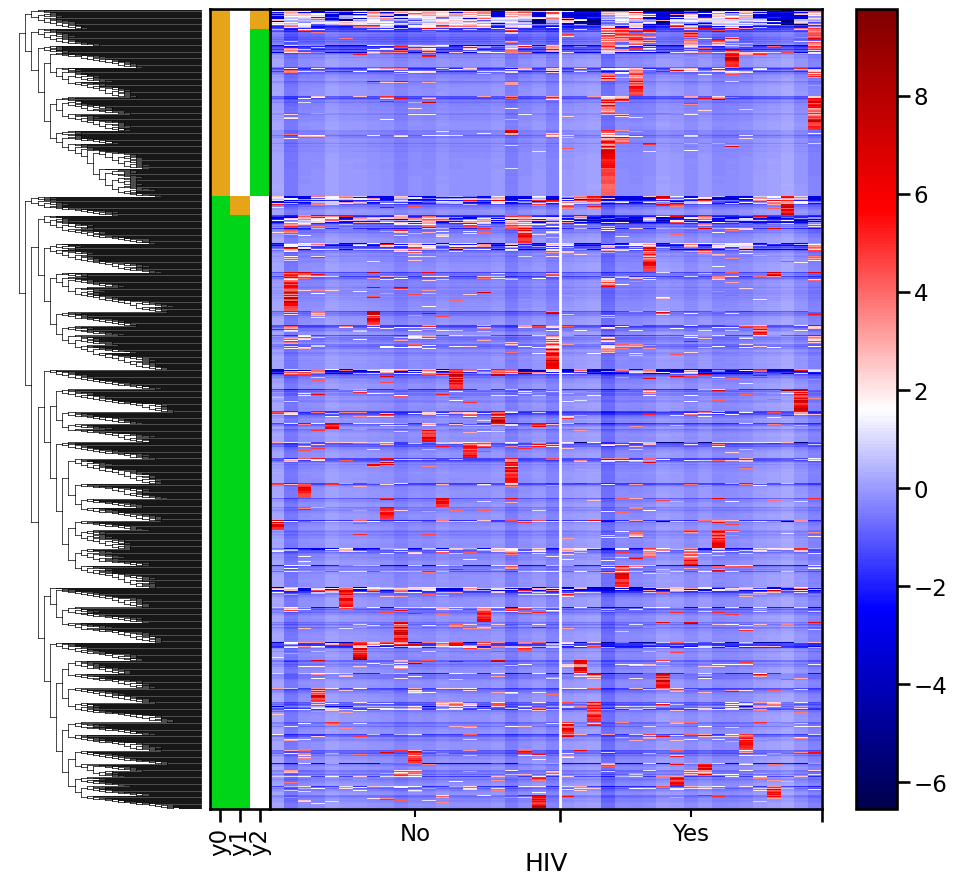

In [41]:
ctable = pd.DataFrame(clr(centralize(table)), index=table.index, columns=table.columns)

sorted_tree = ladderize(tree)

fig = heatmap(ctable, sorted_tree, mdvar=metadata["HIV"], 
            highlights=highlights, figsize=(10, 10), cmap='seismic')

plt.savefig("figures/HIV_gneiss_heatmap_centered_clr.svg", transparent=True, bbox_inches="tight")

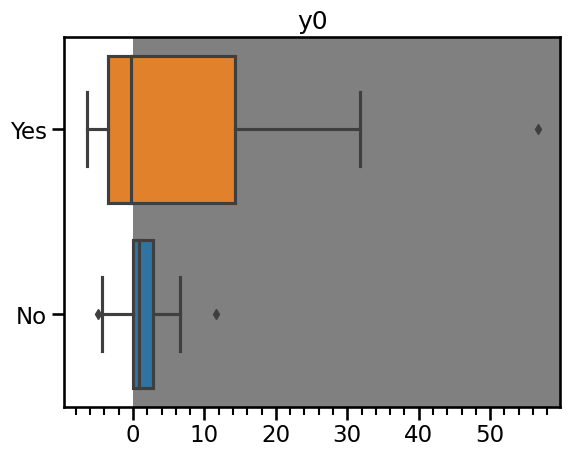

y0 H = 0.09701081973226167, p = 0.7554466907149904 



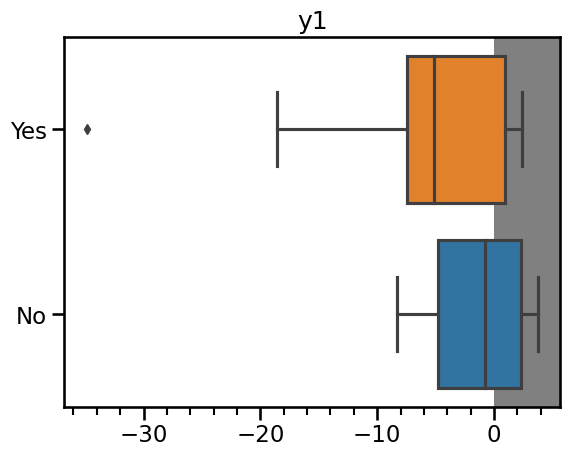

y1 H = 2.2594901888868577, p = 0.1327977721623974 



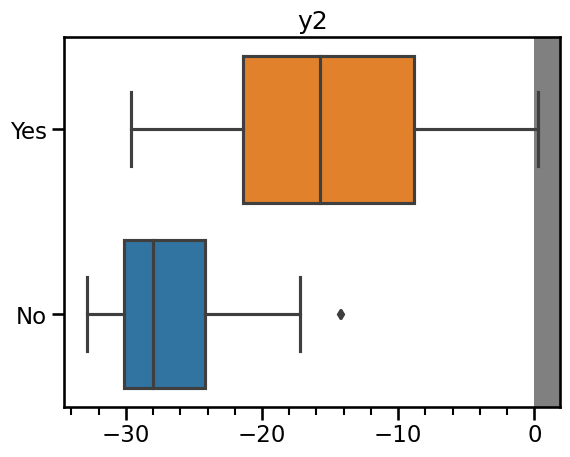

y2 H = 14.274894553456818, p = 0.00015795766184845792 



In [42]:
balance_data = pd.merge(balances, metadata, left_index=True, right_index=True)
for cluster in ['y0', 'y1', 'y2']:
    ax = balance_boxplot(cluster, balance_data, y='HIV',
                         num_color='white', denom_color='grey',
                         palette={'Yes': 'tab:orange', 'No': 'tab:blue'})
    ax.set_title(cluster)
    plt.show()
    H, p = kruskal(balance_data.loc[balance_data["HIV"]=="Yes",cluster],
                   balance_data.loc[balance_data["HIV"]=="No",cluster])
    print(f"{cluster} H = {H}, p = {p} \n")

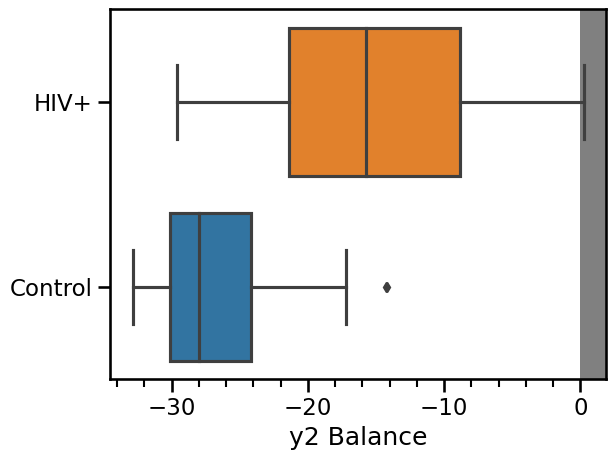

In [43]:
ax = balance_boxplot(cluster, balance_data, y='HIV',
                         num_color='white', denom_color='grey',
                         palette={'Yes': 'tab:orange', 'No': 'tab:blue'})
ax.set_title(None)
ax.set(yticklabels=["HIV+", "Control"],
       xlabel="y2 Balance")

plt.savefig("figures/HIV_y2_balance_boxplot.svg", transparent=True, bbox_inches="tight")

In [44]:
sns.set_context("notebook")

In [45]:
taxa

,kingdom,phylum,class,order,family,genus,species
Feature ID,,,,,,,
db3c5b52eed5154690e045900a2b7a5c,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,None,None
4b948893905a88c441d64c9ae15a32d5,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,None
fcd29acbd2299c2321707445eb33aab2,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,None
989c5cd153548f886eaf000621121b8d,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faecalibacterium,None
f2ea3823a77895718c99c61c9b1ededc,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,None
...,...,...,...,...,...,...,...
966ea19e6eac6dbbb3bb923b42f88a80,d__Bacteria,p__Firmicutes,c__Clostridia,o__Peptostreptococcales-Tissierellales,f__Anaerovoracaceae,g__Family_XIII_AD3011_group,s__metagenome
f29f6894e9300427a0394cd2b2bfb87b,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__human_gut
95e5c6627642ab8d8be00c9a4c7edd62,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Sutterellaceae,g__Sutterella,None


In [46]:
def get_lowest_classification(feature):
    level=5
    lowest = feature.iloc[level]
    uncultured = ["UCG", "uncultured"]
    lowest_found = False
    while lowest_found==False:
        if lowest is None:
            level = level-1
            lowest = feature.iloc[level]
        elif any(uncultured_name in lowest for uncultured_name in uncultured):
            level = level-1
            lowest = feature.iloc[level]
        else:
            lowest_found = True
    return lowest

In [47]:
for i in taxa.index:
    taxa.loc[i,"lowest"] = get_lowest_classification(taxa.loc[i])

In [48]:
taxa

,kingdom,phylum,class,order,family,genus,species,lowest
Feature ID,,,,,,,,
db3c5b52eed5154690e045900a2b7a5c,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,None,None,f__Lachnospiraceae
4b948893905a88c441d64c9ae15a32d5,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,None,g__Agathobacter
fcd29acbd2299c2321707445eb33aab2,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,None,g__Bacteroides
989c5cd153548f886eaf000621121b8d,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faecalibacterium,None,g__Faecalibacterium
f2ea3823a77895718c99c61c9b1ededc,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,None,g__Bacteroides
...,...,...,...,...,...,...,...,...
966ea19e6eac6dbbb3bb923b42f88a80,d__Bacteria,p__Firmicutes,c__Clostridia,o__Peptostreptococcales-Tissierellales,f__Anaerovoracaceae,g__Family_XIII_AD3011_group,s__metagenome,g__Family_XIII_AD3011_group
f29f6894e9300427a0394cd2b2bfb87b,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__human_gut,g__Prevotella
95e5c6627642ab8d8be00c9a4c7edd62,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Sutterellaceae,g__Sutterella,None,g__Sutterella


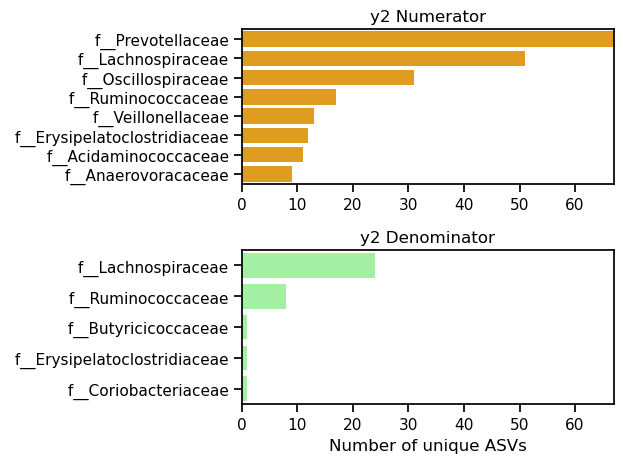

In [49]:
axes = balance_barplots(tree, 'y2', header='family', 
                        feature_metadata=taxa, ndim=8,
                        denom_color='palegreen', 
                        num_color='orange')
axes[0].set(title="y2 Numerator")
axes[1].set(title="y2 Denominator",
            xlabel="Number of unique ASVs")
plt.tight_layout()
plt.savefig("figures/y2_barplot_family.svg", transparent=True, bbox_inches="tight")


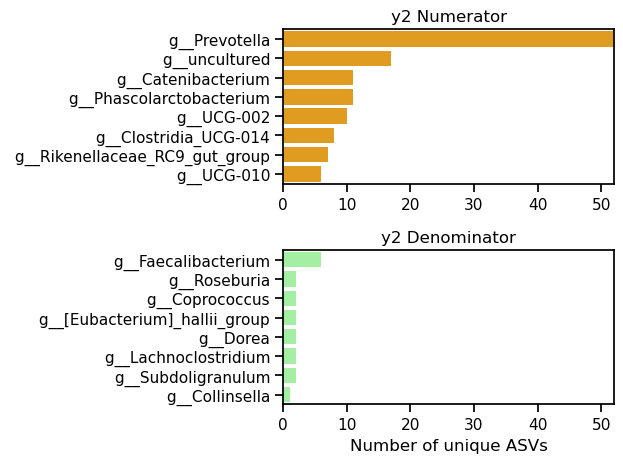

In [50]:
axes = balance_barplots(tree, 'y2', header='genus', 
                        feature_metadata=taxa, ndim=8,
                        denom_color='palegreen', 
                        num_color='orange')
axes[0].set(title="y2 Numerator")
axes[1].set(title="y2 Denominator",
            xlabel="Number of unique ASVs")
plt.tight_layout()
plt.savefig("figures/y2_barplot_genus.svg", transparent=True, bbox_inches="tight")


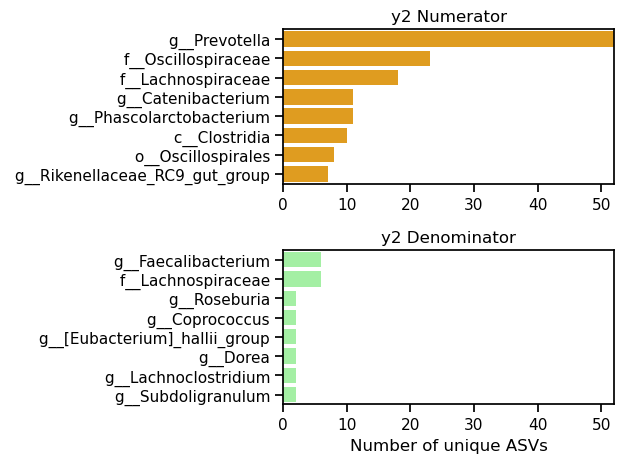

In [51]:
axes = balance_barplots(tree, 'y2', header='lowest', 
                        feature_metadata=taxa, ndim=8,
                        denom_color='palegreen', 
                        num_color='orange')
axes[0].set(title="y2 Numerator")
axes[1].set(title="y2 Denominator",
            xlabel="Number of unique ASVs")
plt.tight_layout()
plt.savefig("figures/y2_barplot_lowest.svg", transparent=True, bbox_inches="tight")

In [52]:
genus

,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Paraprevotella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Ruminococcus,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;__,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Selenomonadaceae;g__Mitsuokella,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__DTU089,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Senegalimassilia,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella,...,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidales_RF16_group;g__Bacteroidales_RF16_group,d__Bacteria;p__Patescibacteria;c__Saccharimonadia;o__Saccharimonadales;f__Saccharimonadaceae;__,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae;g__uncultured,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Aeriscardovia,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Hungatella,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Oligosphaerales;f__Oligosphaeraceae;g__Z20,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__CAG-352,d__Bacteria;p__Firmicutes;c__Bacilli;o__Mycoplasmatales;f__Mycoplasmataceae;g__Ureaplasma,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae;g__Dysgonomonas
H19-01,0.001632,0.064676,0.000637,0.003484,0.101894,0.000000,0.000000,0.013371,0.001736,0.074400,...,0.000000,0.000000,0.000810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H19-02,0.000123,0.000000,0.000000,0.000000,0.057917,0.000000,0.000000,0.081932,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000325
H19-03,0.000099,0.034723,0.000000,0.033572,0.073494,0.000000,0.001009,0.005462,0.000000,0.000395,...,0.000000,0.000000,0.000000,0.000000,0.000165,0.000000,0.000000,0.000000,0.000000,0.000000
H19-03FD,0.093728,0.008099,0.000000,0.000025,0.083198,0.000000,0.000000,0.044617,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000086,0.000000,0.000000,0.000000,0.000000,0.000000
H19-04,0.036174,0.005677,0.012230,0.003048,0.072920,0.000000,0.000648,0.025335,0.004477,0.109227,...,0.000000,0.000057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H19-05,0.006132,0.007133,0.005207,0.003238,0.146819,0.000000,0.000161,0.047649,0.006681,0.146852,...,0.000000,0.000032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H19-06,0.045533,0.005596,0.000000,0.000022,0.025039,0.000000,0.000000,0.003237,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000388,0.000000,0.000029,0.000000,0.000000,0.000000
H19-07,0.012436,0.001350,0.000000,0.013915,0.051690,0.000000,0.000000,0.022133,0.000000,0.000000,...,0.000000,0.000040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000490,0.000000,0.000000
H19-08,0.017429,0.118933,0.000000,0.002817,0.062870,0.000000,0.000168,0.042891,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001980,0.000000,0.000000
H19-09,0.010443,0.026488,0.000000,0.000000,0.048343,0.000000,0.000065,0.018418,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000119,0.000000,0.000000,0.000000,0.000000,0.000000


## Create a L7 tax table for future use

>! qiime taxa collapse \
--i-table noMito_noChloro-filtered-table.qza \
--i-taxonomy taxonomy-silva.qza --p-level 7 \
--o-collapsed-table tax_table.qza

## Cluster heatmap

Doesn't really show anything helpful

In [54]:
L7 = Artifact.load("tax_table.qza").view(pd.DataFrame)

#convert to relative abundances
L7_mat = np.matrix(L7)
L7_mat /= np.sum(L7_mat, axis=1)
L7 = pd.DataFrame(L7_mat, index=L7.index, columns=L7.columns)

In [55]:
from skbio.stats.composition import clr

/Users/johnsterrett/mambaforge/envs/qiime2-2022.11/lib/python3.8/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)
/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/386715890.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


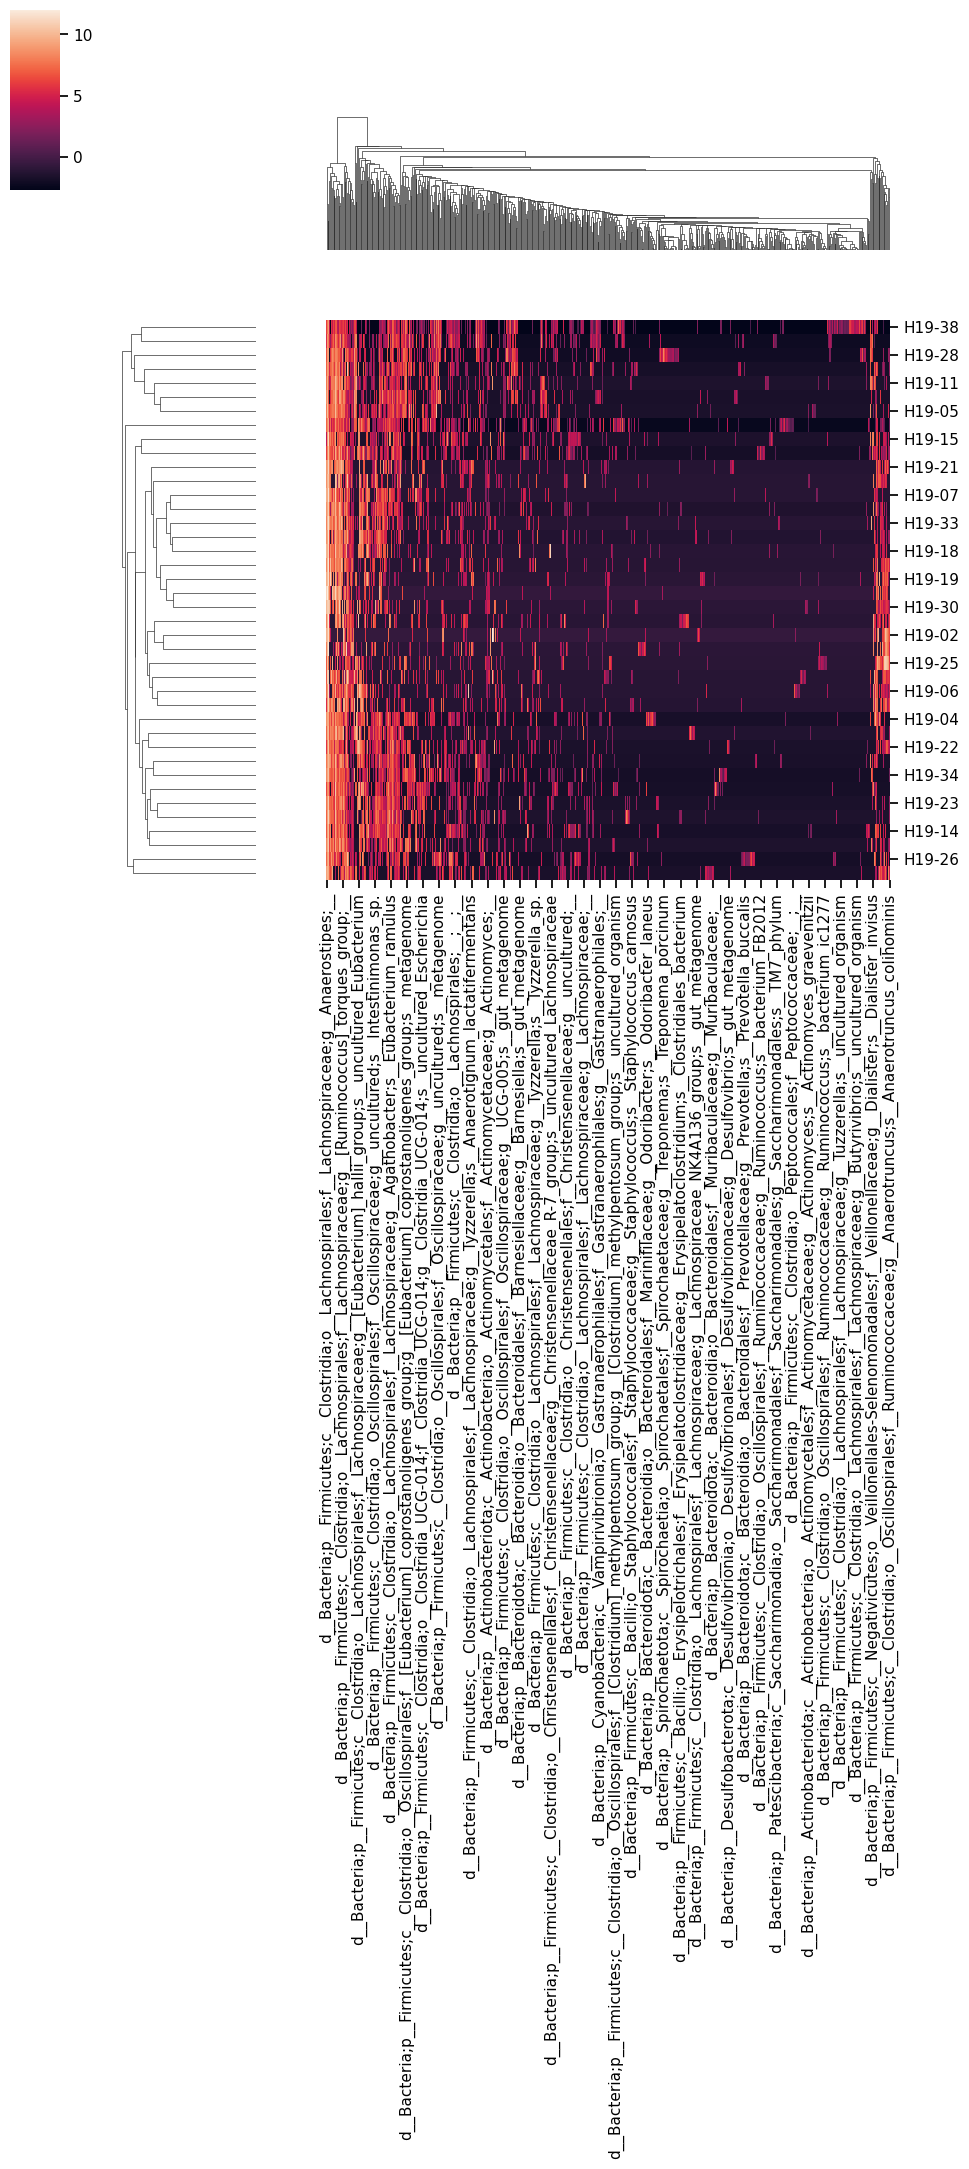

In [56]:
clr_L7 = pd.DataFrame(clr(L7.apply(lambda x: x+0.000001)), 
                      index=L7.index, columns=L7.columns)

sns.clustermap(clr_L7)
plt.tight_layout()

## Fibroscan stats

In [57]:
sns.set_context("talk")

/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/1807269915.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(x="HIV", y="Fibroscan", data=metadata,
/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/1807269915.py:4: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.swarmplot(x="HIV", y="Fibroscan", data=metadata,


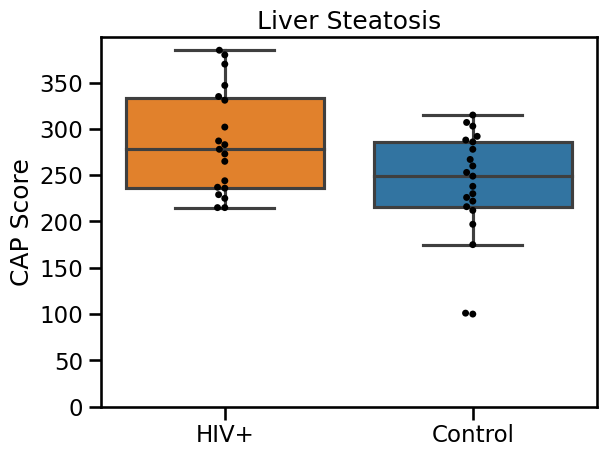

In [58]:
ax = sns.boxplot(x="HIV", y="Fibroscan", data=metadata,
                 palette=["tab:orange", "tab:blue"],
                 showfliers=False)
ax = sns.swarmplot(x="HIV", y="Fibroscan", data=metadata,
                   palette=["black"])

ax.set(ylabel="CAP Score", title="Liver Steatosis",
       xlabel=None, xticklabels=["HIV+", "Control"],
       ylim=0)
plt.savefig("figures/steatosis_HIV.svg", transparent=True, bbox_inches="tight")
plt.show()

/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/3033792581.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(x="HIV", y="Fibroscan_2", data=metadata,
/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/3033792581.py:4: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.swarmplot(x="HIV", y="Fibroscan_2", data=metadata,


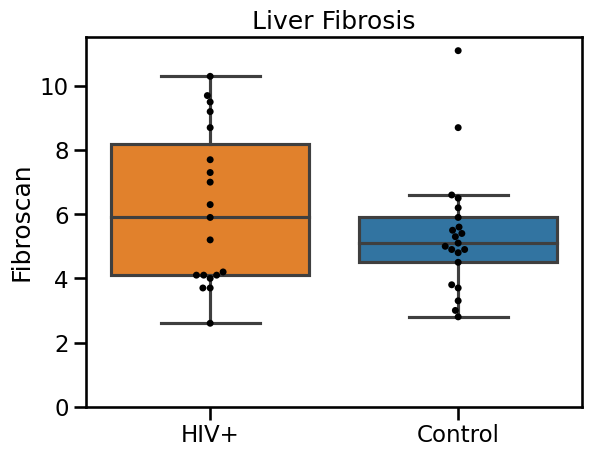

In [59]:
ax = sns.boxplot(x="HIV", y="Fibroscan_2", data=metadata,
                 palette=["tab:orange", "tab:blue"],
                 showfliers=False)
ax = sns.swarmplot(x="HIV", y="Fibroscan_2", data=metadata,
                   palette=["black"])
ax.set(ylabel="Fibroscan", title="Liver Fibrosis",
       xlabel=None, xticklabels=["HIV+", "Control"],
       ylim=0)
plt.savefig("figures/fibrosis_HIV.svg", transparent=True, bbox_inches="tight")
plt.show()

<AxesSubplot: >

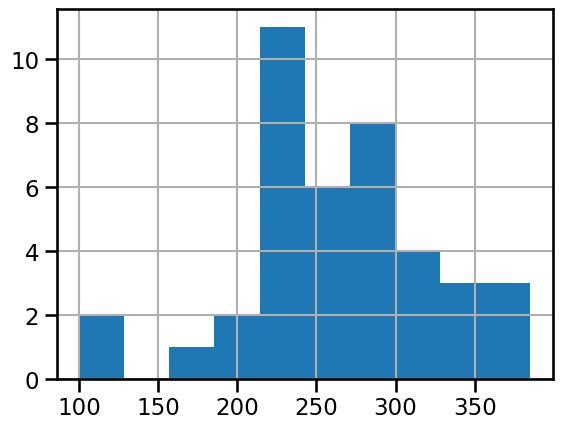

In [60]:
metadata["Fibroscan"].hist()

In [61]:
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        return (f"Welch-Satterthwaite Degrees of Freedom={dof:.4f}")

In [62]:
print("Steatosis: ")
print(
ttest_ind(a=metadata.loc[metadata["HIV"]=="Yes", "Fibroscan"],
          b=metadata.loc[metadata["HIV"]=="No", "Fibroscan"],
          equal_var=False)
)

print(
welch_dof(x=metadata.loc[metadata["HIV"]=="Yes", "Fibroscan"],
          y=metadata.loc[metadata["HIV"]=="No", "Fibroscan"])
)

Steatosis: 
Ttest_indResult(statistic=2.567672416369566, pvalue=0.014311010913911251)
Welch-Satterthwaite Degrees of Freedom=37.8694


In [63]:
print("Fibrosis: ")
print(
ttest_ind(a=metadata.loc[metadata["HIV"]=="Yes", "Fibroscan_2"],
          b=metadata.loc[metadata["HIV"]=="No", "Fibroscan_2"],
          equal_var=False)
)

print(
welch_dof(x=metadata.loc[metadata["HIV"]=="Yes", "Fibroscan_2"],
          y=metadata.loc[metadata["HIV"]=="No", "Fibroscan_2"])
)

Fibrosis: 
Ttest_indResult(statistic=1.165421448242342, pvalue=0.25201401706908716)
Welch-Satterthwaite Degrees of Freedom=33.7717


In [64]:
metadata["faith"] = faith

/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/1429476454.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(x="HIV", y="faith", data=metadata,
/var/folders/ch/dkqxfrp5559f195shx67mp7r0000gn/T/ipykernel_44454/1429476454.py:3: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.swarmplot(x="HIV", y="faith", data=metadata,


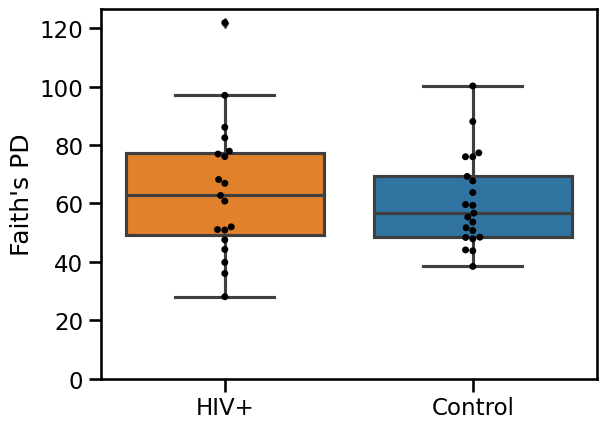

In [65]:
ax = sns.boxplot(x="HIV",y="faith",data=metadata, 
                 palette=["tab:orange", "tab:blue"])
ax = sns.swarmplot(x="HIV", y="faith", data=metadata,
                   palette=["black"])
ax.set(ylabel="Faith's PD",
       xlabel=None, xticklabels=["HIV+", "Control"],
       ylim=0)

plt.savefig("figures/HIV_faith_boxplot.svg",
            transparent=True,
            bbox_inches="tight")
plt.show()

## PCoA

In [66]:
from skbio.stats.ordination import OrdinationResults

In [67]:
u_uni_pcoa = Artifact.load("core-diversity-results/unweighted_unifrac_pcoa_results.qza").view(OrdinationResults)

In [68]:
pcoa_df = u_uni_pcoa.samples
pcoa_df["HIV"] = metadata["HIV"]

In [69]:
u_uni_pcoa.proportion_explained.head()

0    0.156542
1    0.068717
2    0.052664
3    0.047855
4    0.044363
dtype: float64

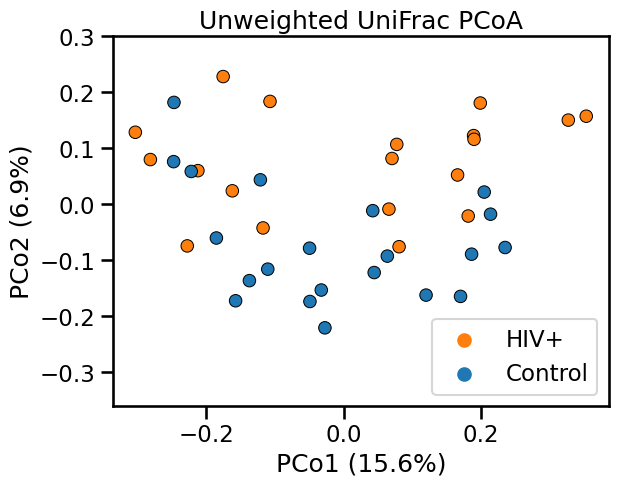

In [70]:
ax = sns.scatterplot(x=0, y=1, hue="HIV", hue_order=["Yes", "No"], palette=["tab:orange", "tab:blue"],
                     edgecolor="black",
                     data=pcoa_df)
handles, labels = ax.get_legend_handles_labels()

plt.clf() # Kinda hacky to get rid of the old plot but still have handles/labels

ax = sns.scatterplot(x=0, y=1, hue="HIV", hue_order=["Yes", "No"], palette=["tab:orange", "tab:blue"],
                     edgecolor='black',
                     data=pcoa_df, legend=False)

ax.legend(handles=handles[:], labels=["HIV+", "Control"], title=None, loc=4)

ax.set(ylim=(-0.36,0.3), ylabel="PCo2 (6.9%)", xlabel="PCo1 (15.6%)",
       title="Unweighted UniFrac PCoA")

plt.savefig("figures/HIV_u_uni_pcoa.svg", transparent=True, bbox_inches="tight")
plt.show()